<a href="https://colab.research.google.com/github/Baldros/DeepLearning/blob/main/DeepApproach(Fining_Tuning_%26_Transfer_Learning).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Apresentação:

Nós outros notebooks, criamos e treinamos redes neurais. No entanto, limitamos esses modelos a um pequeno número de camadas. Neste notebook, faremos uma análise mais profunda da arquitetura dos modelos.

In [11]:
# Bibliotecas:
import numpy as np
import torch.nn as nn
import torch

**Criando dados artificais para o estudo:**

In [12]:
# Features:
x = np.random.rand(200,200);x.shape

(200, 200)

In [13]:
# Resposta:
y = np.random.randint(2, size=x.shape[0]);y.shape

(200,)

# Camadas da Rede Neural:

Quando cada neurônio da camada está conectado a cada neurônio da camada anterior, conforme mostrado em vermelho na figura, eles são chamados de camadas totalmente conectadas (fully connected layers).

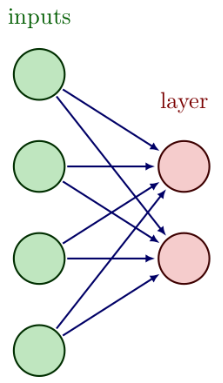

Cada neurônio de uma camada linear realizará uma **operação linear** usando todos os neurônios da camada anterior. Por exemplo, isso significa que cada neurônio usa todos os elementos do vetor de entrada. Portanto, um único neurônio tem $\small N$ mais um parâmetros treináveis, sendo $\small N$ a dimensão de saída da camada anterior, mais um para o bias. Ou seja,

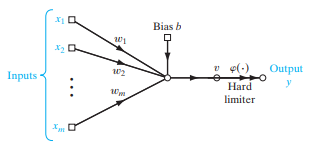

Onde,

* $u_k = \sum_{i=1}^mw_i+x_i$ é a operação linear, uma combinação linear para ser mais exato.

* $b_k$ é o viés. O víes aqui é uma junção de $\beta_0$, *interceptor*, com o erro $\epsilon$.

* $v_k = u_k+b_k$;

* $y = \phi(v_k)$, onde $\phi()$ é a função de ativação.

Estamos trabalhado e continuaremos trabalhando apenas com **redes neurais totalmente conectadas**. Elas são compostas por três tipos de camadas: uma **camada de entrada**, que contém as características do conjunto de dados; uma **camada de saída**, que contém as previsões do modelo; e, finalmente, **camadas ocultas**, que são quaisquer camadas que não sejam a de entrada ou a de saída.

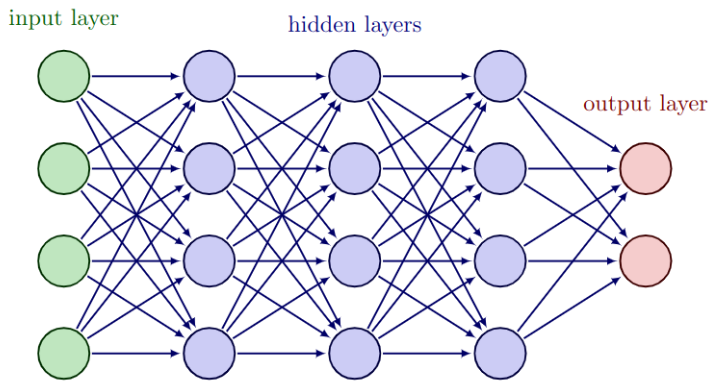

Ao projetar uma *neural network*, as **dimensões** da camada de entrada (a primeira camada) e da camada de saída (a última camada) são fixadas para nós. **O número de neurônios na camada de entrada é o número de características do nosso conjunto de dados**, e **o número de neurônios na camada de saída é o número de classes que queremos prever**.

In [14]:
# Preparando contagem de quantidade de classes:
_, contagem = np.unique(y, return_counts=True)

In [15]:
# Elementos do modelo:
n_features = x.shape[0]
n_classes = sum(contagem.shape) # Dimensão do shape

In [16]:
# Modelo:
model = nn.Sequential(nn.Linear(n_features, 8), # Camada de entrada!
                      nn.Linear(8,4), # Cama oculta 1,
                      nn.Linear(4,n_classes)) # Camada oculta 2.

No código mostrado, `n_features` (`n_underscore_features`) e `n-classes` (`n_underscore_classes`) são determinados pelo nosso conjunto de dados. No entanto, podemos adicionar quantas camadas ocultas quisermos, desde que a dimensão de entrada de uma camada corresponda à dimensão de saída da camada anterior, definição de produto de matrizes.

$$
\textbf{A}_{(m\times{\textbf{n}})}\otimes \textbf{B}_{({\textbf{n}}\times{r})} = \textbf{C}_{(m\times{r})}
$$


Por exemplo, este modelo tem duas camadas ocultas. Quando aumentamos o número de camadas ocultas, aumentamos efetivamente o número de parâmetros no modelo. Também chamamos isso de aumento da **capacidade do modelo**. Ou seja,

$$\textbf{+ hidden layers} = \textbf{+ parâmetros} = \textbf{+ capacidade do modelo} $$

Modelos com mais capacidade podem trabalhar com conjuntos de dados **mais complexos**. Uma **métrica** boa para avaliar a capacidade do nosso modelo é o **número total de parâmetros**. Vamos considerar este modelo composto por duas camadas.

In [17]:
# Metrificando a quantidade de parâmetros do modelo:
model_test = nn.Sequential(nn.Linear(8,4), # Primeira camada
                            nn.Linear(4,2)) # Segunda camada

Podemos contar manualmente os parâmetros: A primeira camada tem $\small 8$ de entrada e $\small 4$ neurônios de saída. Lembrando que,

$$u_k = \sum_{i=1}^n w_kx_i$$

Ou seja, cada conjunto de neurônios de entrada tem o seu respectivo peso, *weight*, que no nosso caso são $\small 8$. Cada camada seguinte tem o seu *bias*, viés. Ou seja,

$$v_k = u_k + b_k$$

Numa *neural network* o *bias* também é treinado ou seja, no conjunto de neurônios de saída existem $\small 9$, $\small 8 \text{ weights }+1 \text{ bias }$ parâmetros treináveis, então ela contém $\small 36$, $\small 4*9$, parâmetros para treinar.

A segunda camada tem $\small 2$ neurônios, cada um deles com $\small 5$ parâmetros treináveis, $\small 4 \text{ weights } + 1 \text{ bias }$, totalizando $\small 2 * 5  = 10$. No total, este modelo tem $\small 36 + 10 =  46$ parâmetros treináveis. Podemos fazer o mesmo cálculo no PyTorch usando o método `.numel` dos tensores, que retorna o número de elementos no tensor. Ao iterar sobre os parâmetros do modelo, podemos adicionar o número de elementos por parâmetro à variável total e verificar se também soma $\small 46$.

In [18]:
# Contando quantidade de parâmetros:
total = 0

for parameter in model_test.parameters():
  total += parameter.numel()

print(f'{total} parâmetros treináveis no total.')

46 parâmetros treináveis no total.


# Learning Rate and Momentum:

O treinamento de uma *neural nework* pode ser resumido em um problema de [otimização](https://pt.wikipedia.org/wiki/Otimiza%C3%A7%C3%A3o), ou seja, queremos minimizar uma **função objetivo**, chamada nesse contexto de **perda**, ***loss***. Veremos agora um conceito de **otimizador** e como ele pode impactar drásticamente o treinamento.

## Stochastic Gradiente Descent (SGD):

O [Stochastic Gradient Descent](https://en.wikipedia.org/wiki/Stochastic_gradient_descent) é um aprimoramento do algorítmo [Gradient Descent](https://en.wikipedia.org/wiki/Gradient_descent) de modo a construir um optimizador mais optimizado. O insight da descida gradiente estocástica é que o gradiente é uma expectativa. A expectativa pode ser estimada aproximadamente usando um pequeno conjunto de amostras. Especificamente, em cada etapa do algoritmo, podemos amostrar um ***minibatch***, minilotes, de exemplos
$B=\{x^{(1)},...,x^{(m')}\}$ extraído **uniformemente** do conjunto de treinamento. O tamanho do **minibach** $m'$ é normalmente escolhido para ser um número relativamente pequeno de exemplos, variando de $\small 1$ a algumas centenas. Crucialmente, $\small m'$ geralmente é mantido fixo como o tamanho do conjunto de treinamento $\small m$ cresce. Podemos ajustar um conjunto de treinamento com bilhões de exemplos usando atualizações calculadas
em apenas cem exemplos, tal que

$$g = \frac{1}{m'} \nabla_{\theta} \sum_{i=1}^{m'}L(x^{(i)},y^{(i)},\boldsymbol{\theta})$$

Ou seja, a ideia é que, normalizando o gradiente pelo ***minibach***, isso melhora a eficiência computacional dos cálculos e maximiza a velocidade do gradiente de chegar ao valor otímo.

In [19]:
# Stochastic Gradient Descent
sgd = torch.optim.SGD(model.parameters(),lr=.01,momentum=.95);sgd

SGD (
Parameter Group 0
    dampening: 0
    differentiable: False
    foreach: None
    fused: None
    lr: 0.01
    maximize: False
    momentum: 0.95
    nesterov: False
    weight_decay: 0
)

Onde,

* `lr`: é o ***learning rate*** que controla a taxa de aprendizado. Basicamente é o tamanho dos passos do SGD. Geralmente é um número fixo e pequeno, e isso envolve um certo cuidado com a escolha de seu valor para ser pequeno o suficiente para não passar pelo valor ótimo, mas que também não torne o processo muito lento.

* `momentum`: É um parâmetro que controla a inércia do otimimizador. Esse hiperparâmetro regula a possibilidade de mudança na direção do gradiente descendent, ou seja, ele permite que o gradiente não fique preso num **mínimo local** de modo que auxilia na busca pelo **mínimo global**.

Em resumo, são eles **hiperparâmetros** de um otimizador e não só podem ser ajustados ao treinar um modelo, como na prática devem ser ajustados para o seu melhor funcionamento.

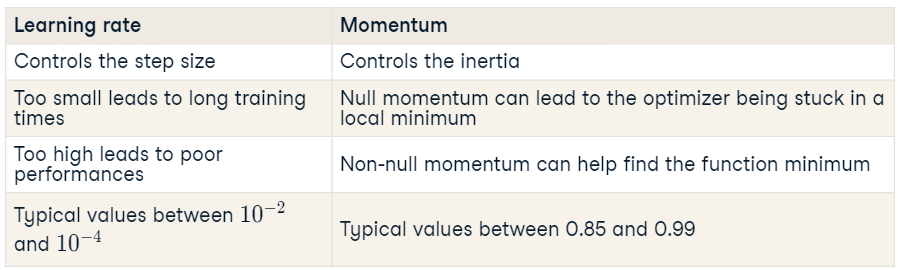

# Inicialização dos Layers:

 Já vimos como os pesos, *weights*, de uma *neural network* são atualizados durante o treinamento, graças ao *backpropagation* e ao *gradient descente*, *Stochastic Gradient Descent*, para ser mais específico. No entanto, não analisamos os valores dos pesos no início do treinamento, antes de qualquer passo do otimizador ser executado. Da mesma forma que a normalização de dados, os pesos de uma camada linear também são normalizados.

In [22]:
# Analisando Layer:
layer = nn.Linear(64,128)
print(layer.weight.min(),layer.weight.max())

tensor(-0.1249, grad_fn=<MinBackward1>) tensor(0.1250, grad_fn=<MaxBackward1>)


In [37]:
valor = 0
for parameter in layer.parameters():
    print(parameter.numel(),parameter.shape)
    valor += parameter.numel()
print(f'Quantidade total de parmâtros: {valor}')

8192 torch.Size([128, 64])
128 torch.Size([128])
Quantidade total de parmâtros: 8320


Observamos que os pesos da camada são inicializados com valores pequenos, aqui estão entre -0.125 e 0.125. Em geral, ao treinar uma rede neural, inicializamos os pesos de cada camada com valores pequenos. Então, por que isso é necessário? Anteriormente, discutimos como a saída de um neurônio em uma camada linear é uma soma ponderada das saídas da camada anterior.
$$u_k = \sum_{i=1}^n w_kx_i$$

Ao manter tanto os dados de entrada quanto os pesos da camada pequenos, garantimos que as saídas de nossas camadas permaneçam pequenas. Uma camada pode ser inicializada de diferentes maneiras, por exemplo, usando a **distribuição uniforme**, $\small w_1=w_2=...=w_k$. A inicialização de camadas é um tópico ativo de pesquisa. Pytorch oferece uma maneira fácil de inicializar os pesos das camadas com o módulo `nn.init`.

In [49]:
# Inicializando camada com distribuição uniforme:
nn.init.uniform_(layer.weight)
print(layer.weight.min(),layer.weight.max())

tensor(9.6917e-05, grad_fn=<MinBackward1>) tensor(0.9999, grad_fn=<MaxBackward1>)


# Transferência de Aprendizado:

Na prática, os engenheiros de aprendizado de máquina raramente treinam um modelo a partir de pesos aleatórios inicializados. Em vez disso, eles confiam numa conceito muito poderoso chamado *transfer learning*. *Transfer learning* consiste em utilizar um modelo treinado para uma tarefa primeira e reutilizar os seus pesos para uma tarefa secundária. O *save* e o *load* de pesos em Pytorch pode ser feita utilizando as funções `torch.save` e `torch.load`. Estas funções funcionam em **qualquer tipo de objeto Pytorch**, seja uma **simples camada** ou um **modelo completo**.

In [51]:
# Salvando os pesos:
torch.save(layer, 'layer.pt')

# Carregando pesos:
layer_load = torch.load('layer.pt');layer_load

Linear(in_features=64, out_features=128, bias=True)

In [52]:
valor = 0
for parameter in layer_load.parameters():
    print(parameter.numel(),parameter.shape)
    valor += parameter.numel()
print(f'Quantidade total de parmâtros: {valor}')

8192 torch.Size([128, 64])
128 torch.Size([128])
Quantidade total de parmâtros: 8320


# Fining-Tune:

O *Fining-Tune* nada mais é que um tipo de aprendizado transferido. Às vezes, a tarefa secundária é similar à primeira e queremos realizar um tipo específico de *transfer learning*, chamado *fine-tuning*. Neste caso, carregamos pesos de um modelo anteriormente treinado, **mas treinamos o modelo com uma taxa de aprendizagem menor**. Podemos mesmo treinar partes de uma rede, se decidimos que algumas camadas da rede não necessitam ser treinadas e escolhemos congelar elas.

Um princípio comum é congelar as primeiras camadas da rede e "*fine-tunar*" as camadas mais próximas da saída. Para os modelos do [Hugging Face](https://huggingface.co/), fazemos isso o tempo todo. Isto pode ser conseguido ao definir o atributo `requires_grad` de cada parâmetro como `False`. Aqui usamos a método `named_parameters()` da rede, que retorna o nome e o parâmetro próprio. Definimos o atributo `requires_grad` do peso da primeira camada para `False`.

In [53]:
# Instanciando Modelo:
model = nn.Sequential(nn.Linear(64,128),
                      nn.Linear(64,128))

# Estruturando fine-tuning:
for name, param in model.named_parameters():
    if name == '0.weight':
        param.requires_grad = False